主成分分析（PCA：Principal Component Analysis）是经常使用的一个降维方法。该notebook是对[Principal Component Analysis in 3 Simple Steps](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html)的学习记录、补充和翻译，原文章对PCA内部的实现分解成3步，以方便理解其原理。

三个步骤分别为：

1. 对协方差矩阵进行特征分解，得到特征值、特征向量
2. 选取主成分
3. 特征变换


## Introduction

现代数据的大小不仅是对计算机硬件的挑战，也是许多机器学习算法性能的主要瓶颈。 PCA分析的主要目标是识别数据中的模式; PCA旨在检测变量之间的相关性。 如果存在变量之间的强相关性，那么降低维度的尝试才有意义。 简而言之，这就是PCA所关心的：查找高维数据中最大方差的方向，并将其投影到较小维的子空间上，同时保留大部分信息。

### PCA vs LDA

线性判别分析（LDA：Linear Discriminant Analysis）和PCA都是线性变换方法。 PCA产生最大化数据方差的方向（主成分），而LDA还旨在找到使不同类之间的间隔最大化的方向，这可以用于模式分类问题（而PCA“忽略”数据的类别标签）。

换句话说，PCA将整个数据集投射到一个不同的特征（子）空间，LDA尝试确定一个合适的特征（子）空间，以保证能够区分出不同的类别。


### PCA and Dimensionality Reduction

通常，PCA的目标是将 $ d $ 维数据集的投影到 $ k $ 维子空间（其中 $ k < d$ ），以便在减少数据集尺寸的条件下，保留大部分信息的同时增加计算效率。 这里，最重要的问题是 $ k $ 的大小如何确定？

之后，我们将计算数据集的特征向量（主成分），并将它们收集到投影矩阵中。 每一个特征向量对应一个特征值，特征向量确定一个方向，特征值则可以理解为相应特征向量的“长度”或“大小”。 如果某些特征值比其他特征值大得多，那么通过丢弃“较少信息”的特征来缩减数据集到较小的维度的子空间是合理的。


### A Summary of the PCA Approach

- 标准化数据
- 从协方差矩阵或相关矩阵中获取特征向量和特征值，或进行奇异向量分解。
- 按降序对特征值进行排序，并选择对应于 $k$ 个最大特征值的 $k$ 个特征向量，其中 $k$ 是新特征子空间（$k≤d$）的维数。
- 由选定的 $k$ 个特征向量构建投影矩阵 $W$
- 通过 $W$ 转换原始数据集 $X$ 以获得 $k$ 维特征子空间 $Y$


## Preparing the Iris Dataset

### About Iris

在后面我们将使用UCI机器学习库中着名的[“Iris”数据集](https://archive.ics.uci.edu/ml/datasets/Iris)。

iris数据集来自于对3种共150株鸢尾花的测量。

数据集的3个类别（标签）是：

1. 山鸢尾（Iris-setosa） (n=50)
2. 变色鸢尾（Iris-versicolor） (n=50)
3. 维吉尼亚鸢尾（Iris-virginica） (n=50)

数据集中的4个特征为：

1. 萼片长度 sepal length（单位：cm）
2. 萼片宽度 sepal width（单位：cm）
3. 花瓣长度 petal length（cm）
4. 花瓣宽度 petal width（cm）

![iris](iris.png "iris")

### Loading the Dataset

这里用pandas库来进行数据处理。

In [6]:
import pandas as pd

df = pd.read_csv(
    filepath_or_buffer = 'input/iris.data',
    header=None,
    sep=',')

df.columns = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how = 'all', inplace = True) # drops the empty line at file-end

df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


将数据划分为特征 $ \boldsymbol{X} $ 和标签 $\boldsymbol{y} $。

In [31]:
X = df.ix[:, 0:4].values
y = df.ix[:, 4].values

print('X type: %s. X shape: ' % type(X), X.shape)
print('y type: %s. y shape: ' % type(y), y.shape)

X type: <class 'numpy.ndarray'>. X shape:  (150, 4)
y type: <class 'numpy.ndarray'>. y shape:  (150,)


可以看出iris数据共有150个样本，每个样本有4个特征和1个标签。特征 $ \boldsymbol{X} $ 的每一行可以看成一个向量 $\boldsymbol{x} $，其中：

$$ \boldsymbol{x} ^ \text{T} = \left[ \begin{matrix} x_1 \\ x_2 \\ x_3  \\ x_4 \end{matrix} \right]  = \left[ \begin{matrix} \text{sepal_length} \\ \text{sepal_width} \\ \text{petal_length}  \\ \text{petal_width} \end{matrix} \right] $$

### Exploratory Visualization

为了对3种花的4个特征的分布有一个直观的认识，我们来绘制它们的直方图。

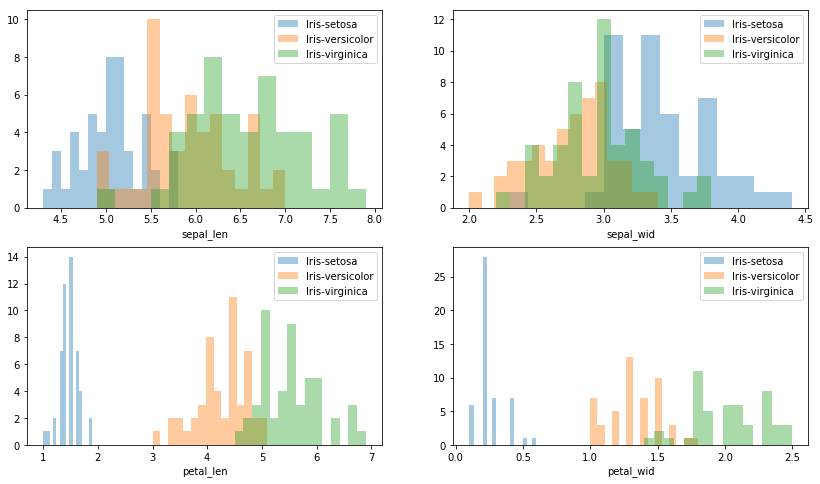

In [128]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

labels = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
features = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']

plt.figure(figsize=(14, 8))
for cnt in range(4):
    plt.subplot(2, 2, cnt+1)
    for lab in labels:
        plt.hist(X[y==lab, cnt], bins=15, alpha=0.4, label=lab)
        plt.xlabel(features[cnt])
    
    plt.legend()
plt.show()

### Standardizing

在计算协方差矩阵之前是否要进行数据标准化取决于原始特征的测量尺度。 由于PCA的特征子空间是通过最大化沿着轴方向的方差得到的，所以标准化数据是有意义的，特别是如果它是以不同的尺度进行测量的话。 虽然，Iris数据集中的所有特征都以厘米为单位，但是我们依然将数据转换为单位尺度（均值为0，方差为 1），这是许多机器学习算法的最佳性能的要求。


In [60]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X)

## 1 - Eigendecomposition - Computing Eigenvectors and Eigenvalues

协方差矩阵（或相关矩阵）的特征向量和特征值是PCA的“核心”：特征向量（主成分）确定新特征空间的方向，特征值决定其大小。 换句话说，特征值反映了数据沿着新特征轴方向的方差。

### Covariance Matrix

The classic approach to PCA is to perform the eigendecomposition on the covariance matrix $\Sigma$, which is a $d×d$ matrix where each element represents the covariance between two features. The covariance between two features is calculated as follows:

$$ \sigma_{jk} = \frac{1}{n-1} \sum_{1}^{n} \left(\ x_{ij} - \bar{x_{j}} \right)\left(\ x_{ik} - \bar{x_{k}} \right) $$

We can summarize the calculation of the covariance matrix via the following matrix equation: 

$$ \Sigma = \frac{1}{n-1} \left( \left( \boldsymbol{X} - \bar{x} \right)^{\text{T}} \left( \boldsymbol{X} - \bar{x} \right) \right)$$

where $\bar{x} $ is the mean vector $ \bar{x} = \frac{1}{n} \sum{x_i} $.
The mean vector is a dd-dimensional vector where each value in this vector represents the sample mean of a feature column in the dataset.

In [65]:
mean_vec = np.mean(X_std, axis=0)

cov_mat = (X_std - mean_vec).T.dot(X_std - mean_vec) / (X_std.shape[0] - 1)

print("Covariance Matrix: \n", cov_mat)

Covariance Matrix: 
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [68]:
cov_mat2 = np.cov(X_std.T)
print("Covariance Matrix: \n", cov_mat2)

Covariance Matrix: 
 [[ 1.00671141 -0.11010327  0.87760486  0.82344326]
 [-0.11010327  1.00671141 -0.42333835 -0.358937  ]
 [ 0.87760486 -0.42333835  1.00671141  0.96921855]
 [ 0.82344326 -0.358937    0.96921855  1.00671141]]


In [71]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print("Eigenvectors: \n", eig_vecs)
print("EigenValues: \n", eig_vals)

Eigenvectors: 
 [[ 0.52237162 -0.37231836 -0.72101681  0.26199559]
 [-0.26335492 -0.92555649  0.24203288 -0.12413481]
 [ 0.58125401 -0.02109478  0.14089226 -0.80115427]
 [ 0.56561105 -0.06541577  0.6338014   0.52354627]]
EigenValues: 
 [ 2.93035378  0.92740362  0.14834223  0.02074601]


## 2 - Selecting Principal Components

### Sorting Eigenpairs

In [80]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues in descending order:\n')
for pair in eig_pairs:
    print(pair[0])

Eigenvalues in descending order:

2.93035377559
0.927403621517
0.148342226482
0.0207460139956


### Explained Variance

In [83]:
tot = np.sum(eig_vals)

var_exp = [val * 100 / tot for val in sorted(eig_vals, reverse = True)]

cum_var_exp = np.cumsum(var_exp) # 累积求和

print(var_exp)
print(cum_var_exp)

[72.770452093801353, 23.030523267680628, 3.6838319576273895, 0.51519268089063586]
[  72.77045209   95.80097536   99.48480732  100.        ]


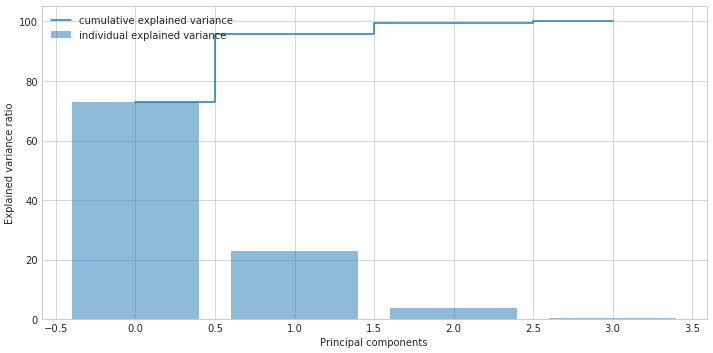

In [129]:

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(4), var_exp, alpha=0.5, label='individual explained variance')
    plt.step(np.arange(4), cum_var_exp, where='mid', label='cumulative explained variance')
    
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.legend(loc='best')
    
    plt.tight_layout()

plt.show()

### Projection Matrix

In [123]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(4, 1), eig_pairs[1][1].reshape(4, 1)))

print(matrix_w)

[[ 0.52237162 -0.37231836]
 [-0.26335492 -0.92555649]
 [ 0.58125401 -0.02109478]
 [ 0.56561105 -0.06541577]]


## 3 - Projection Onto the New Feature Space

In [124]:
X_pca = X_std.dot(matrix_w)

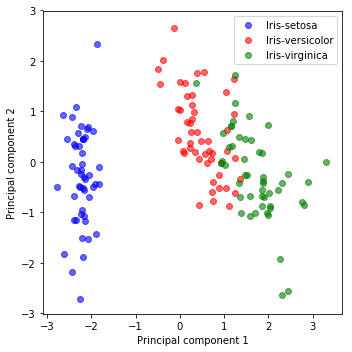

In [170]:
colors = {'Iris-setosa': 'blue', 'Iris-versicolor': 'red', 'Iris-virginica': 'green'}

plt.figure(figsize=(5, 5))

for key in colors:
    plt.scatter(X_pca[y==key, 0], X_pca[y==key, 1], c=colors[key], label=key, alpha=0.6)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Shortcut - PCA in scikit-learn

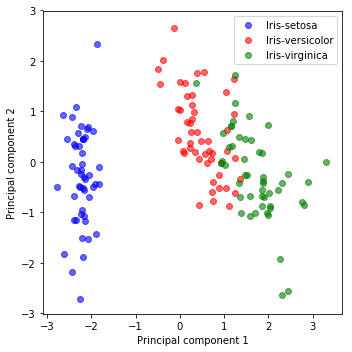

In [174]:
from sklearn.decomposition import PCA

sk_pca = PCA(n_components=2)
X_sk_pca = sk_pca.fit_transform(X_std)

colors = {'Iris-setosa': 'blue', 'Iris-versicolor': 'red', 'Iris-virginica': 'green'}

plt.figure(figsize=(5, 5))

for key in colors:
    plt.scatter(X_sk_pca[y==key, 0], -X_sk_pca[y==key, 1], c=colors[key], label=key, alpha=0.6)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()